# Google Colab Setup

In [ ]:
#@title Setup Google Colab by running this cell only once (ignore this if run locally) {display-mode: "form"}
import sys 
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone https://github.com/epfl-exts/aml24-master-class.git
        
    # Copy files required to run the code
    !cp -r "aml24-master-class/text_classification/data" "aml24-master-class/text_classification/tools.py" .
    
    # Install packages via pip
    !pip install -r "aml24-master-class/colab-requirements.txt"
    
    # Restart Runtime
    import os
    os.kill(os.getpid(), 9)

# Build a spam detector

### Task 

We want to build a Spam detector which, given examples of spam emails (e.g. flagged by users) and examples of regular (non-spam, also called "ham") emails, learns how to flag new unseen emails as spam or non-spam.

### Data

In the previous notebooks we have covered the following steps:
* Load the data
* Text preprocessing
* Feature extraction
* Data exploration

The different feature sets can be loaded with the `load_feature_space()`-function. The options for the feature sets are:
* "num": numerical features
* "text": text features
* "num_text": numerical and text features combined
* "embedding": embedding features

### In this notebook

Our aim is to build a simple spam detector. We will start by exploring the different datasets, before we will build a simple spam detector and evaluate the model. We will use the following steps:
* Load the features
* Split the data into training and test set
* Train a simple spam detector
* Evaluate the model
* Analyze misclassified samples



## Load the data

In [1]:
# Load libraries and helper functions
%run data_prep_tools.py
%run EDA_tools.py
%run modeling_tools.py

In [2]:
# Load the data sets
num_features_df = load_feature_space("num", no_labels=False)
text_features_df = load_feature_space("text", no_labels=False)
num_text_features_df = load_feature_space("num_text", no_labels=False)
embeddings_df = load_feature_space("embedding", no_labels=False)
labels = load_labels()

Numeric features loaded
Data includes labels in the column 'spam_label'
The data set has 5832 rows, 14 columns
Text features loaded
Data includes labels in the column 'spam_label'
The data set has 5832 rows, 10001 columns
Numeric and text features loaded
Data includes labels in the column 'spam_label'
The data set has 5832 rows, 10014 columns
Email embeddings loaded
Data includes labels in the column 'spam_label'
The data set has 5832 rows, 769 columns
5832 labels loaded
Labels found: [1 0]


Let's check the number of samples per class in the data.

Samples per class (%):
non-spam    70.3
spam        29.7
Name: spam_label, dtype: float64




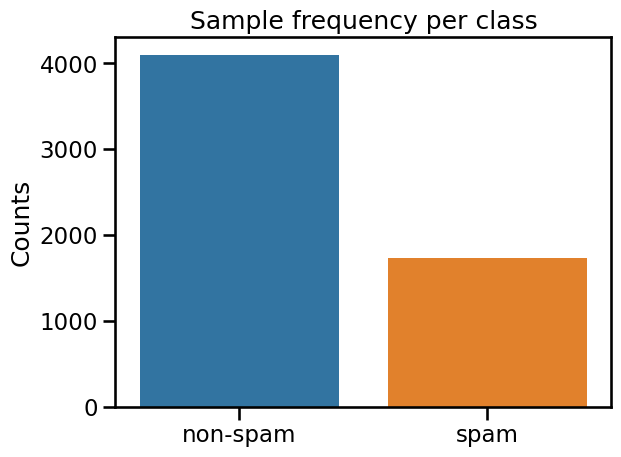

In [3]:
plot_class_frequency(labels)

<div class="alert alert-success">


<h3>Questions</h3>

Suppose you applied a **very naive approach** to the spam detection problem **that uses none of the features**: _You just either classify all emails as "spam" or as "non-spam"._

__Q1.__ How many emails would be classified correctly in each case?  

__Q2.__ Which approach would be more successful?

This naive kind of approach is useful to establish a **baseline** for the performance of our more complex classifiers.  
In this notebook we will build various spam detectors and compare their performance to this baseline.
</div>

#### Give your answer here:

1.    



2.







# Model building

We are now ready to build our machine learning model for detecting spams. 

Throughout this notebook we will use a **Logistic Regression classifier**. Here is why:
- It is a simple and efficient model for binary classification tasks. 
- It is a good baseline for more complex models. 
- It is fast to train and thus allows us to quickly iterate on our model and try out different settings.
- It is also easy to interpret and allows us to explore where our model makes mistakes.

Below you will
- build a first simple model.
- tune the main hyperparameter `C` for the model using a cross-validated grid search.
- explore different feature sets and see how they affect the performance of the model.
- explore the effect of different evaluation metrics.
- Explore misclassified samples.

### A first trial

As a first trial, we will use the `num` feature set with a simpl. The accuracy is defined as the number of correct predictions divided by the total number of predictions.  

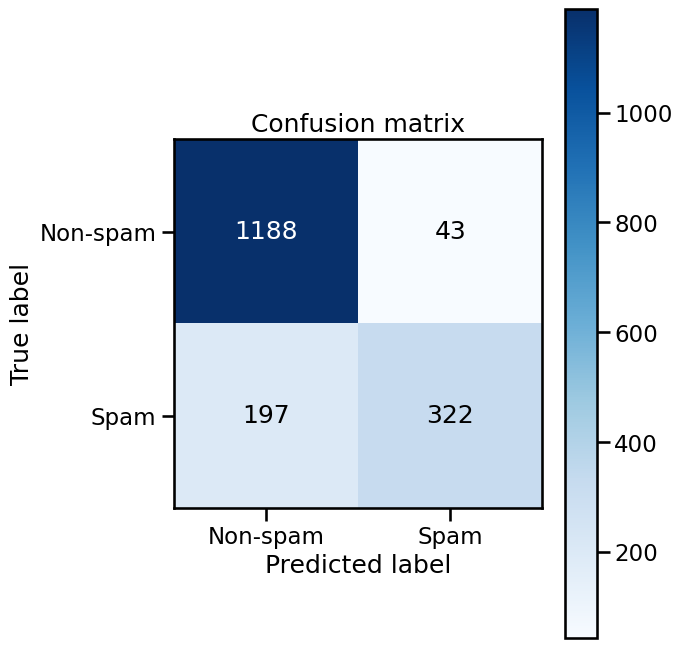

In [4]:
# Train/test splitting
df_train, df_test = train_test_split_(num_features_df)

# Fit model on the train data
model = fit_model(df_train, C=1)

# Print predictions on test set
plot_confusion_matrix(df_test, model)

<div class="alert alert-success">


<h3>Questions</h3>

Let's explore the plot above. 

__Q1.__ Which numbers tell use the correct predictions for each class?

__Q2.__ Which numbers tell use the failed predictions for each class?

__Q3.__ What class faired better?


</div>

#### Give your answer here:

1.    




2.




3.







The classification report provides us with different 4 metrics to evaluate the performance of our model: 3 metrics for each class and the overall accuracy. 

The **accuracy** is the number of correct predictions divided by the total number of predictions.

The **precision** is the number of true positives divided by the number of true positives plus the number of false positives.

The **recall** is the number of true positives divided by the number of true positives plus the number of false negatives.

The **f1-score** is the harmonic mean of precision and recall.

In [5]:
# Print classification report for test set
classification_report_(df_test, model)

              precision    recall  f1-score   support

    Non-spam       0.86      0.97      0.91      1231
        Spam       0.88      0.62      0.73       519

    accuracy                           0.86      1750
   macro avg       0.87      0.79      0.82      1750
weighted avg       0.87      0.86      0.85      1750



You can consider changing the `C` parameter in the `fit_model` function to see how it affects the model performance. But this is seen as bad practice be cause you are tuning the mmodel to the test set, which you also use for evaluation.

Instead let's use a more appropriate approach below.

### A more systematic approach to fine tuning

We will use 5-fold cross-validation. So the validation sets are automatically created internally. The test set will be used to `evaluate` the performance of our model. The process will automatically choose the best model for us. We also collect all the results from the cross-validation so we can plot them below.

In [6]:
%run modeling_tools.py

In [7]:
# Train/test splitting
df_train, df_test = train_test_split_(num_features_df)
# text_features_df takes 45mins

# Fit model on the train data
model, cv_results = fit_log_reg_model(df_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


#### Tracking overfitting

Below we plot the results of the cross-validation. The x-axis shows the different values of `C` we tried, and the y-axis shows the metric of the model evaluated on the training set (blue) and on the validation set (orange). The red cross shows the value of the best `C` we found.

We are interested in the gap between the training and validation curves. If the gap is small, it means that our model is not overfitting and generalizes well to unseen data. If the gap is large, it means that our model is overfitting. This indicates that the model has learned irrelevant information like noise that does not reflect the general pattern. In such a case we need to find ways to adjust the model to reduce the gap and improve the performance on the validation set.

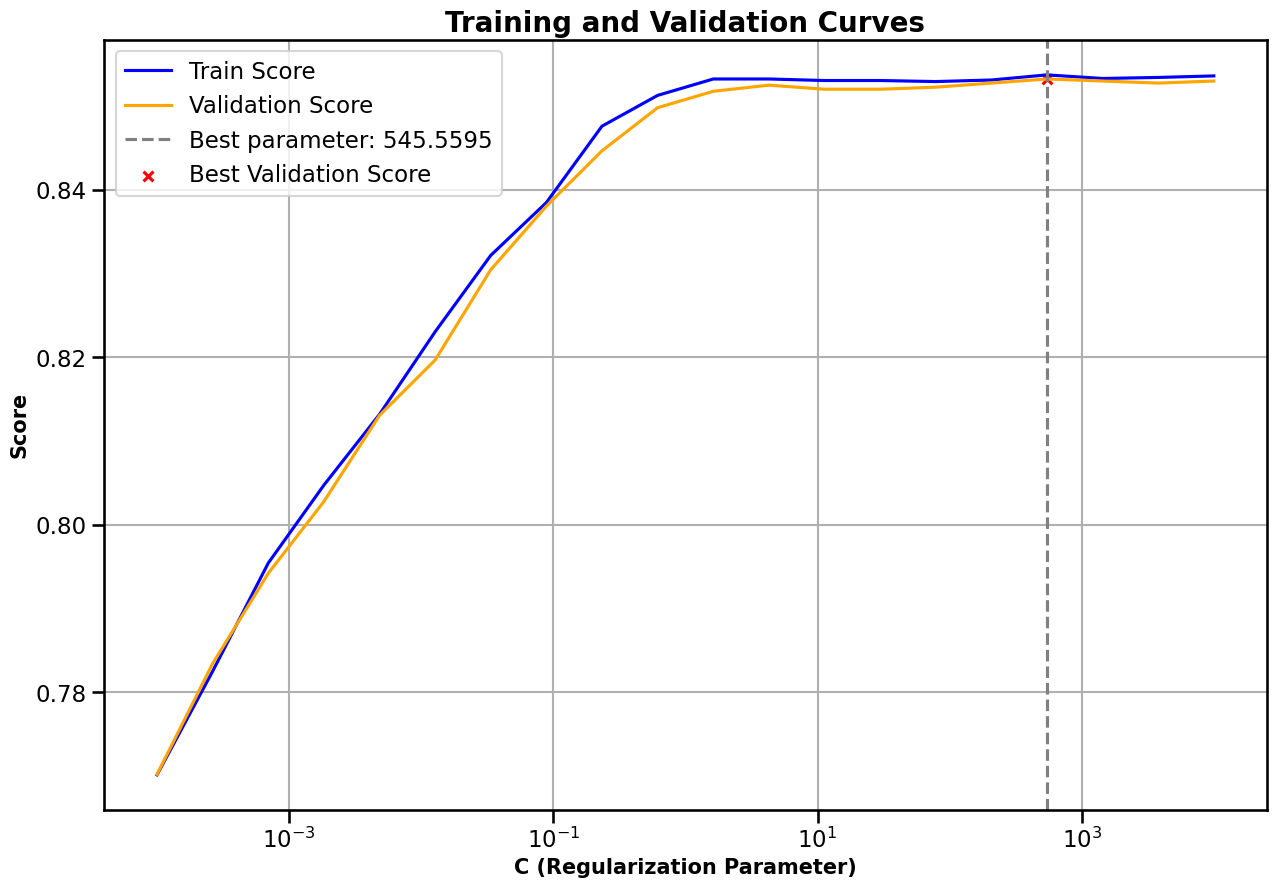

In [8]:
viz_cv_results(cv_results, show_table=False, plot_confidence=False, plot_fit_time=False)

<div class="alert alert-success">


<h3>Questions</h3>

Let's explore the plot above. 

__Q1.__ Do we observve overfitting i.e. a large gap between the training and validation curves?

__Q2.__ What happens when C is very small and when it is very large?


</div>

#### Give your answer here:

1.    




2.











### Model evaluation

              precision    recall  f1-score   support

    Non-spam       0.86      0.96      0.91      1231
        Spam       0.88      0.62      0.73       519

    accuracy                           0.86      1750
   macro avg       0.87      0.79      0.82      1750
weighted avg       0.86      0.86      0.85      1750



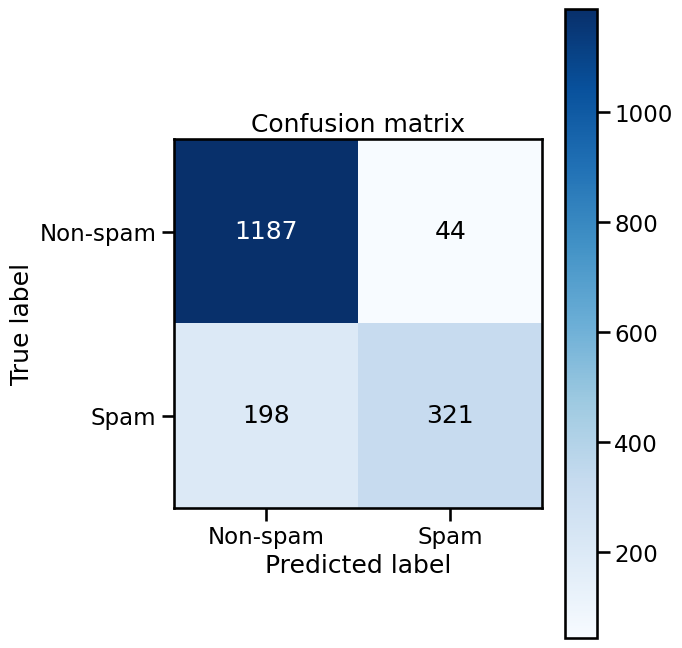

In [9]:
# Print classification report for test set
classification_report_(df_test, model)

# Print predictions on test set
plot_confusion_matrix(df_test, model)

### Get more insights into the model

In the Logistic Regression the coefficients tell us how much each feature contributes to the overall prediction. The larger the absolute value of a coefficient, the more important the corresponding feature is for the model. 

For the numerical features and the text features we always have positive feature values. Thus positive coefficients contribute more to the `spam` class while negative coefficients contribute more to the `non-spam` class.

For the embedding features we have both positive and negative feature values. Thus we need to look at the contributions (feature values times coefficients) to judge the impact on the overall prediction. This will help us understand the model's behavior better and identify which features are driving the predictions for particular samples.

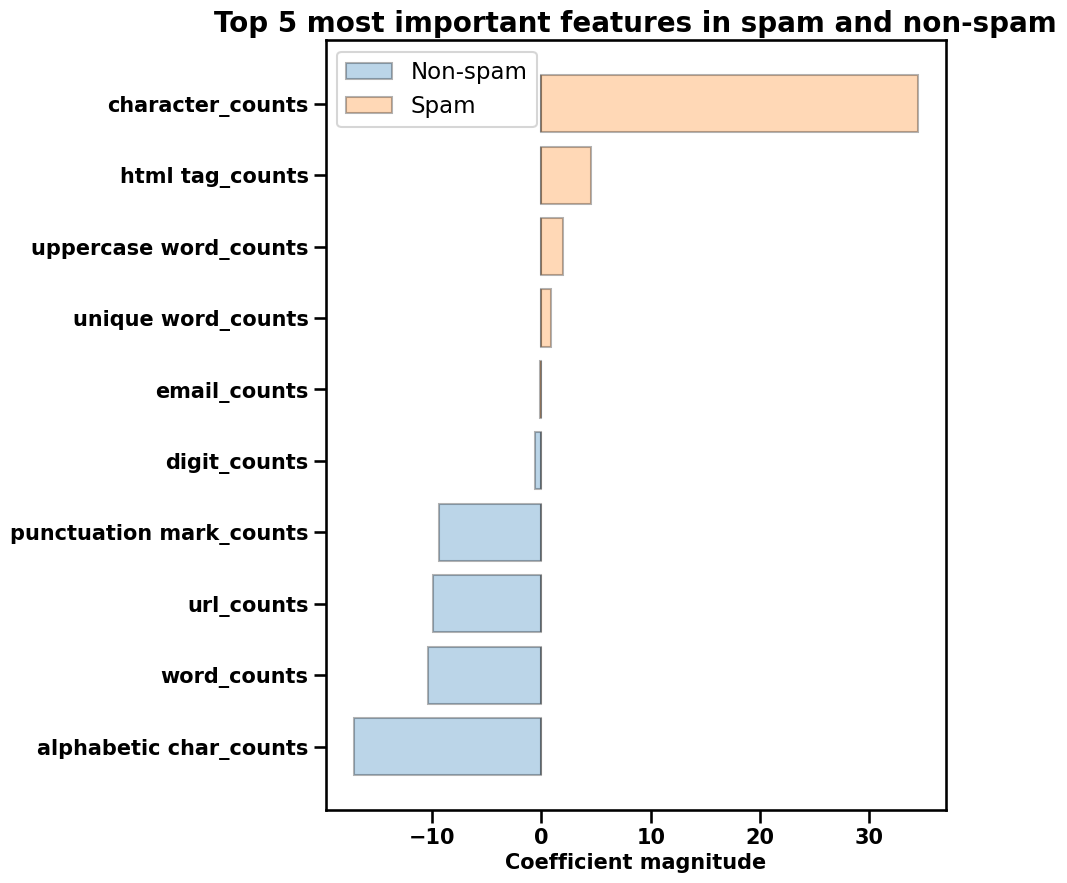

In [10]:
visualize_coefficients(model, df_train, n_top_features=5)

### How sure was the model of its predictions?
The Logistic Regression model can return the probabilities of each class for each sample. The probabilities are between 0 and 1, and the sum of the probabilities for each sample is 1. This allows us to assess the confidence of the model's predictions.

Below we plot the probabilities of the spam class and colour them by their actual class. Low probabilities (close to 0) indicate that the model is very sure that the sample is not spam, while high probabilities (close to 1) indicate that the model is very sure that the sample is spam.

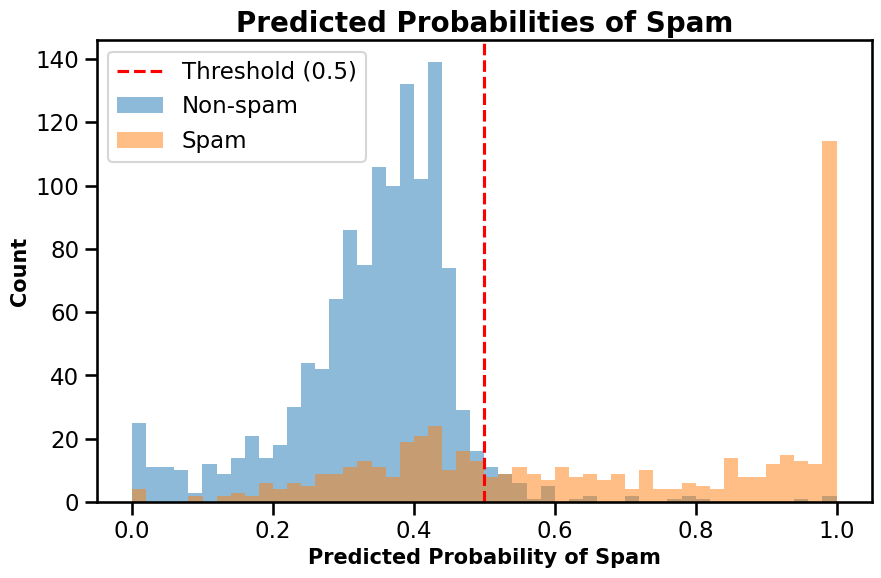

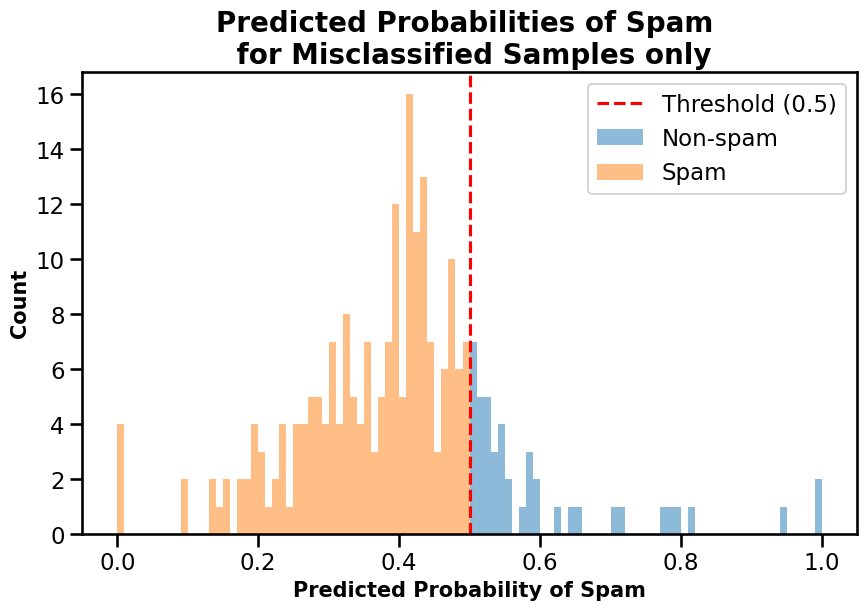

In [11]:
plot_prediction_certainties(df_test, model, log_scale=False)

<div class="alert alert-success">


<h3>Questions</h3>

Let's explore the plot above. 

__Q1.__ When the model misclassified a sample, is it usually very sure of its prediction, or kind of doubtful?

Careful with interpretation when the top plot using a log-scale. This means that the values are not evenly spaced. You can change the setting.

</div>

#### Give your answer here:

1.    















### Error analysis :: Where does our model fail?

We will now analyze the misclassified mails in order to get some insights on where the model failed to make correct predictions. The *error_analysis* function below will show us the top features responsible for the model making a decision of prediction whether the mail is spam or non-spam.

In [12]:
%run modeling_tools.py

Coefficients: 13
Number of misclassified samples: 242

Overview for document index: 10

Original Text
On Saturday, September 21, 2002, at 10:59 PM, Joseph S. Barrera III wrote: > Better yet, tell me
where I should be listening for new music now that > P2P is dead and I still can't pick up KFJC very
well. KFJC has a MP3 stream at kfjc.org. I'd also recommend radioparadise.com. I remember the
Suburban Lawns, but I don't know what became of them. Apropos of nothing: "Spirited Away" is
amazing. Go see it now. -- whump 

Cleaned Text
saturday september joseph barrera wrote better tell listening music dead pick kfjc kfjc stream kfjc
recommend radioparadise remember suburban lawns dont know apropos spirited away amazing whump 


Predictions

Actual class:   Non-spam
Predicted class:   Spam

Predicted probabilities
Non-spam: 0.4724
Spam: 0.5276



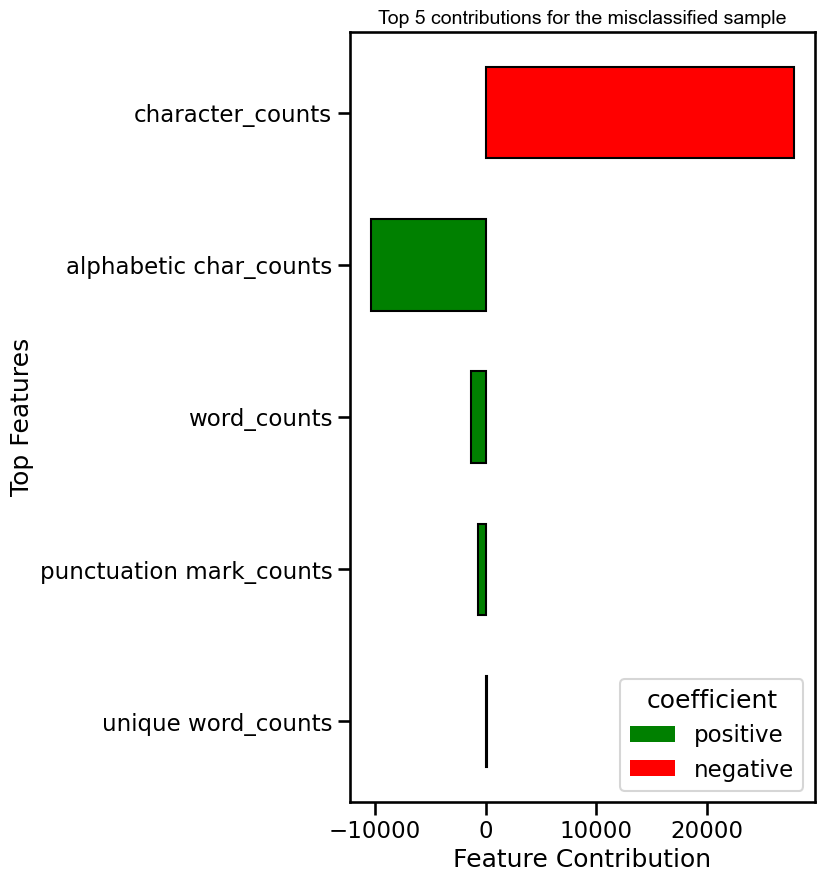

In [13]:
error_analysis(df_test, model, doc_nbr=10, n_top_coeff=5, color_by_coeff_sign=True)

<div class="alert alert-info">


# YOUR TURN!!!

We have copied the above code blocks again below. You can use them to build your own spam detector now. 

There are a number of things you can adapt:

### Change the feature space

We have loaded 4 feature spaces at the start of the notebook. Simply replace `num_features_df` with `text_features`, `num_text_features`, or `embedding_features` in the code below to use a different feature space.

Warning: The feature spaces using text features are quite slow and will take quite a while to run the fine-tuning with cross-validation. So instead use the `fit_model`-function and vary `C=1`directly. (Yes as we said above that is not a good practice, but it is allows you to explore the model.)

### Change the metric used for fine-tuning

You can change the scoring function inside `fit_log_reg_model(df_train)`.  

The current default value is `None`, which means that the model will use the default scoring function for the Logistic Regression model. This is the accuracy score. 

However, you can also change it to `"precision"`, `"recall"`, or `"f1"` and check how the results change. More options are given [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

What happens to the confusion matrix?

### Explore other settings

You will likely have to change some of the other parameters in the visualisations, etc. to make them more interpretable.

</div>

In [30]:
# To make things easier:
# Change your settings here and then run the cell below

feature_space = embeddings_df
# options are: num_features_df, text_features_df, num_text_features_df, embeddings_df


C = 1
# options to try are: 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000


scoring = "precision"
# options include: 'accuracy', 'f1', 'precision', 'recall'

              precision    recall  f1-score   support

    Non-spam       1.00      0.98      0.99      1231
        Spam       0.95      0.99      0.97       519

    accuracy                           0.98      1750
   macro avg       0.97      0.98      0.98      1750
weighted avg       0.98      0.98      0.98      1750



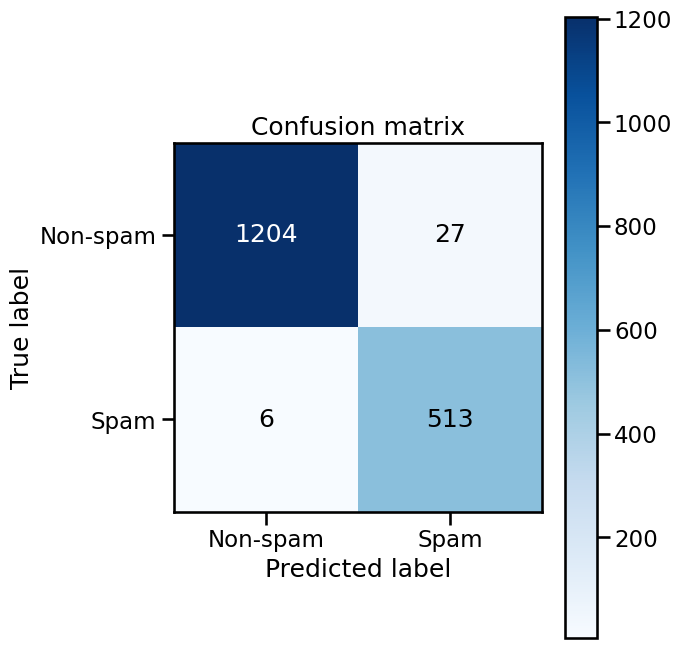

In [23]:
# Train/test splitting
df_train, df_test = train_test_split_(feature_space)

# Fit model on the train data
model = fit_model(df_train, C=C)

# Print classification report for test set
classification_report_(df_test, model)

# Print predictions on test set
plot_confusion_matrix(df_test, model)

In [31]:
# Train/test splitting
df_train, df_test = train_test_split_(feature_space)
# text_features_df takes 45mins

# Fit model on the train data
model, cv_results = fit_log_reg_model(df_train, scoring=scoring)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


#### Tracking overfitting

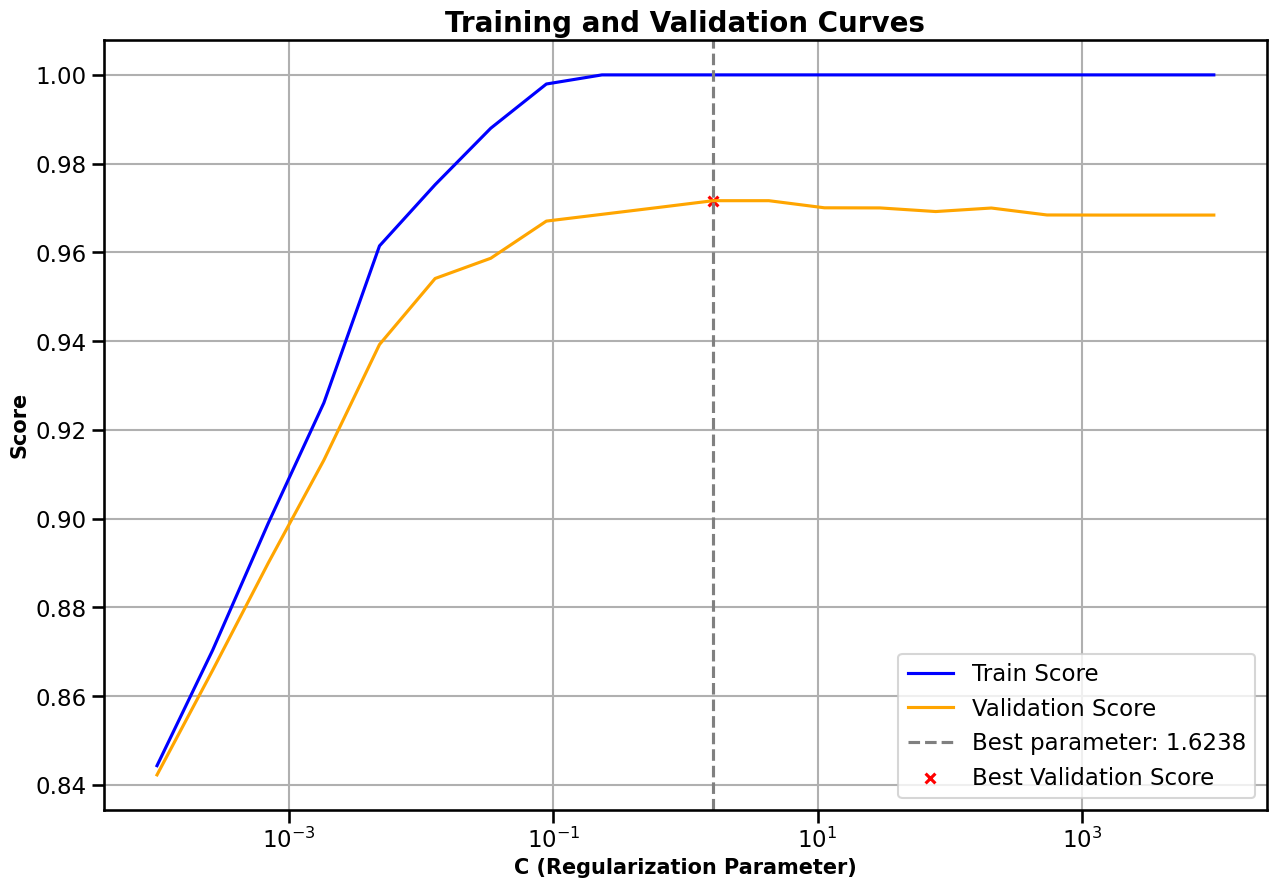

In [32]:
viz_cv_results(cv_results, show_table=False, plot_confidence=False, plot_fit_time=False)

### Model evaluation

              precision    recall  f1-score   support

    Non-spam       0.99      0.99      0.99      1231
        Spam       0.98      0.98      0.98       519

    accuracy                           0.99      1750
   macro avg       0.99      0.99      0.99      1750
weighted avg       0.99      0.99      0.99      1750



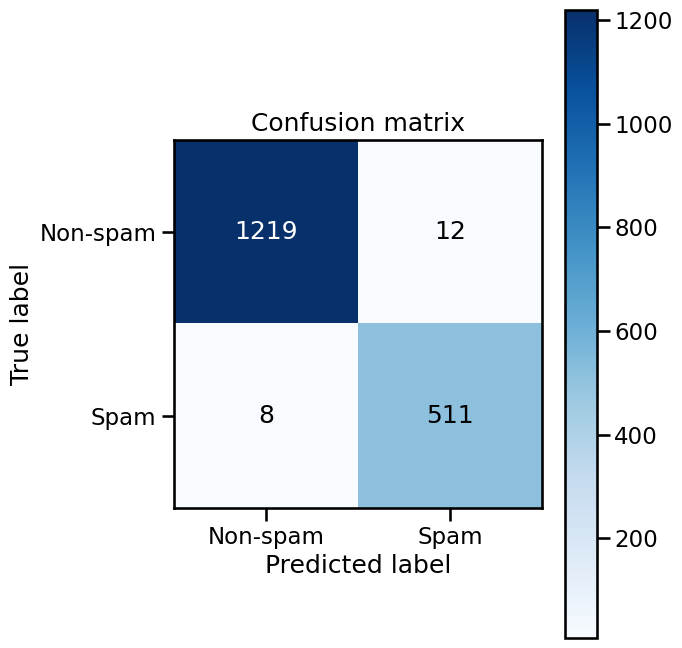

In [33]:
# Print classification report for test set
classification_report_(df_test, model)

# Print predictions on test set
plot_confusion_matrix(df_test, model)

### Get more insights into the model

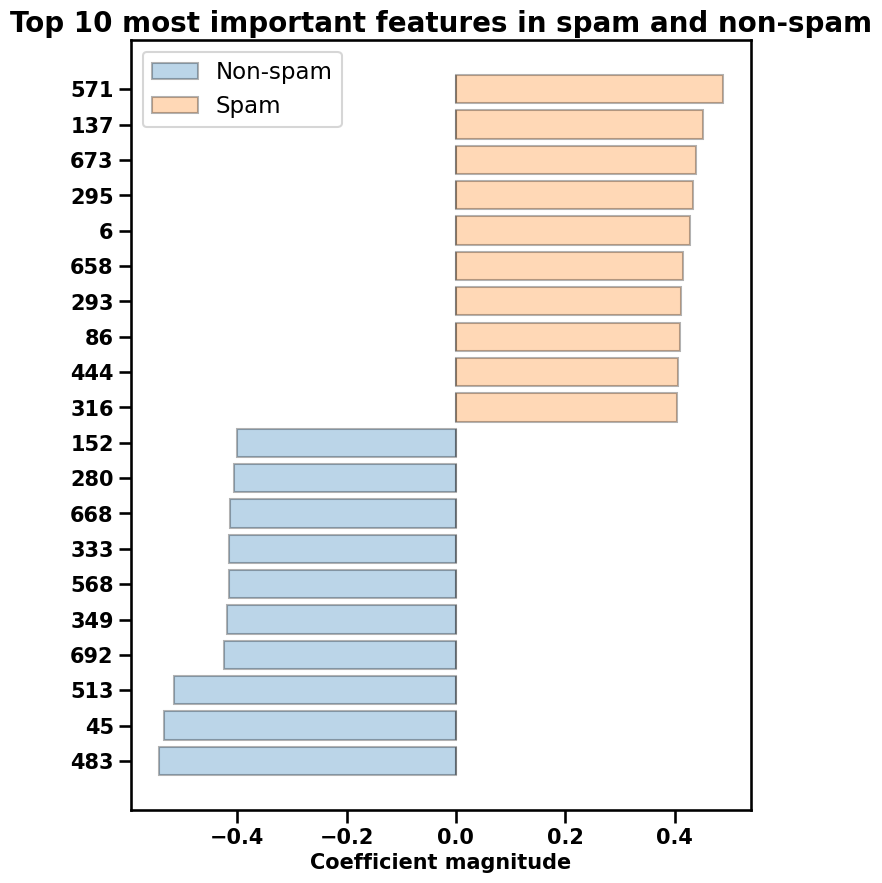

In [34]:
visualize_coefficients(model, df_train, n_top_features=10)

### How sure was the model of its predictions?


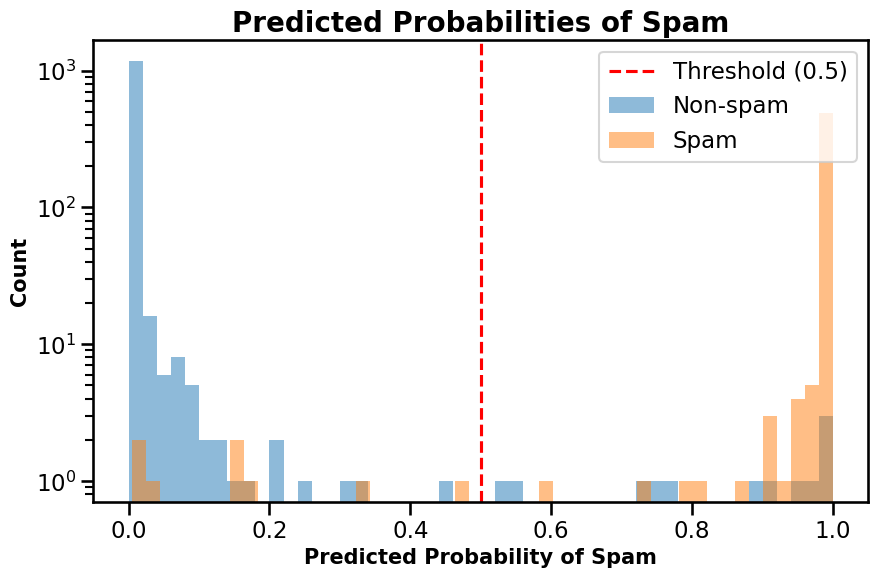

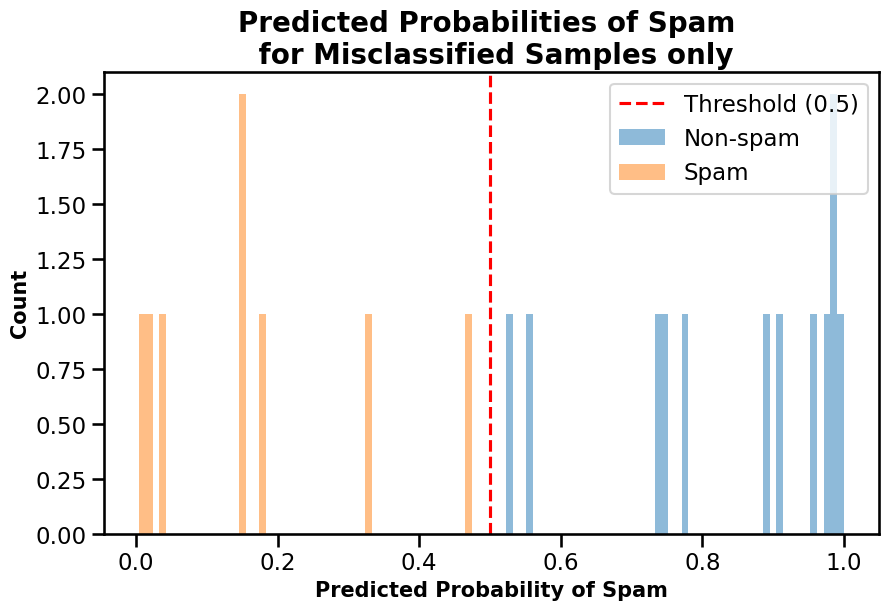

In [35]:
plot_prediction_certainties(df_test, model, log_scale=True)

### Error analysis :: Where does our model fail?

Coefficients: 768
Number of misclassified samples: 20

Overview for document index: 10

Original Text
Ryanair in partnership with Primary Insurance offer excellent value travel insurance from
£7.00GBP/9.00 Euro per person for 31 day cover. Annual travel insurance* from £45.00GBP/63.00 Euro,
includes 24 days winter sports cover ! Our travel insurance provides a high standard of cover.
Summary of Cover Medical Expenses up to £2 million Personal Liability up to £2 million Personal
Effects & Baggage up to £750 Personal Accident Maximum Benefit £15,000 Hospital Benefit up to £300
Cancellation up to £500 Curtailment up to £500 Travel Delay up to £60 Missed Departure up to £300
Personal Money up to £500 Legal Expenses up to £5000 Holiday Abandonment up to £500 All figures in
Sterling pounds To book your Primary travel insurance policy click
http://www.primarytrade.co.uk/internetsales/ryanair/ or call Ryanair Direct Reservations now on:
0871 246 0002 (UK) 0818 304 304 (IRELAND) Primary Insuran

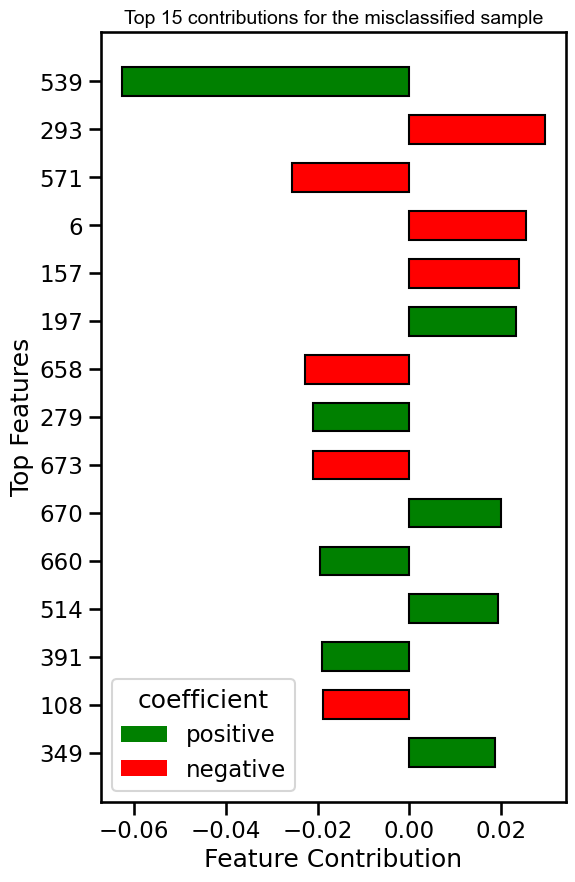

In [36]:
error_analysis(df_test, model, doc_nbr=10, n_top_coeff=15, color_by_coeff_sign=True)